In [197]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed 
from numba import jit

from sklearn.linear_model import LinearRegression
import scipy.linalg
from sklearn import linear_model
import sklearn.linear_model as skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from PIL import Image

from imageio import imread

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [198]:
# Define the Franke Fumction
def frankeFunction(x1,x2,sig2):
    noise = np.random.normal(0,sig2,x1.shape)
    term1 = 0.75*np.exp(-(0.25*(9*x1-2)**2) - 0.25*((9*x2-2)**2))
    term2 = 0.75*np.exp(-((9*x1+1)**2)/49.0 - 0.1*(9*x2+1))
    term3 = 0.5*np.exp(-(9*x1-7)**2/4.0 - 0.25*((9*x2-3)**2))
    term4 = -0.2*np.exp(-(9*x1-4)**2 - (9*x2-7)**2)
    return term1 + term2 + term3 + term4 + noise

# Create the data points in mesh grid form
def createDataPoints(n, sig2):
    x1 = np.arange(0, 1, 1/n)
    x2 = np.arange(0, 1, 1/n)
    x1_d, x2_d = np.meshgrid(x1,x2)
    y_d = frankeFunction(x1_d,x2_d,sig2)
    return x1_d, x2_d, y_d.ravel()

def computeFrankeValues(x_data, y) :    
    N = x_data.shape[0]
    for i in range(N) :
        y[i] = frankeFunction(x_data[i,0], x_data[i,1],0)

def plotFranke(XX,YY,n, method):
    M = 100
    x_data = np.vstack([XX.ravel(), YY.ravel()]).T
    yy_data = np.zeros(shape=(x_data.data.shape[0]))
    computeFrankeValues(x_data, yy_data)
    
    X1 = createDesignMatrix(XX,YY,2)
    X2 = createDesignMatrix(XX,YY,3)
    X3 = createDesignMatrix(XX,YY,4)
    X4 = createDesignMatrix(XX,YY,5)
    
    z_tilde1 = predict(X1,yy_data, method, n)
    z_tilde2 = predict(X2,yy_data, method, n)
    z_tilde3 = predict(X3,yy_data, method, n)
    z_tilde4 = predict(X4,yy_data, method, n)

    Z1 = np.reshape(z_tilde1.T, XX.shape)
    Z2 = np.reshape(z_tilde2.T, XX.shape)
    Z3 = np.reshape(z_tilde3.T, XX.shape)
    Z4 = np.reshape(z_tilde4.T, XX.shape)
    
    Z = np.stack((Z1, Z2, Z3, Z4))
    print(Z.shape)
    
    ZF = np.reshape(yy_data.T, XX.shape)
    
    fig = plt.figure(figsize=(14,14))
    
    for i in range(1,5):
        ax = fig.add_subplot(2, 2, i, projection='3d')
        surf = ax.plot_surface(XX, YY, Z[i-1].squeeze(), cmap=cm.coolwarm,
                                linewidth=0, antialiased=False)
        ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(5))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        ax.view_init(10, 45)
        ax.set_title("p = %s" %(i+1))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        fig.colorbar(surf, shrink=0.5, aspect=5)
    
    plt.savefig(f'frankePlots{method}.png')
    plt.show()
    #    return XX,YY,Z,ZF

    
# Create the design matrix with all possible combinations
@jit
def createDesignMatrix(x1, x2, n=4):
    if len(x1.shape) > 1:
        x1 = np.ravel(x1)
        x2 = np.ravel(x2)

    N = len(x1)
    p = int((n+1)*(n+2)/2)
    X = np.ones((N,p))

    for i in range(1, n+1):
        q = int(i*(i+1)/2)
        for j in range(i+1):
            X[:,q+j] = (x1**(i-j))*(x2**j)
    return X

# Predict the outcome using matrix inversion
def predict(X, y_data, method, lmb=4):
    if method == 'OLS':
        beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y_data)
        y_tilde = X @ beta
        return y_tilde
    if method == 'Ridge':
        N = np.size(X,1)
        I = np.eye(N)
        beta_ridge = np.linalg.inv(X.T @ X + lmb*I) @ X.T @ y_data
        y_tilde = X @ beta_ridge
        return y_tilde
    if method == 'Lasso':
        clf_lasso = skl.Lasso(alpha=lmb).fit(X,y_data)
        y_tilde = clf_lasso.predict(X)
        return y_tilde
        
# Calculate the mean square error (MSE)
def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Calculate the coefficient of determination (R2)
def R2(y_data, y_model):
    n = np.size(y_data)
    return 1 - np.sum((y_data-y_model)**2)/np.sum((y_data-(np.sum(y_data)/n))**2)

#Scale the data and split them for training and testing
def Scale(X_train, X_test):
    XX = np.copy(X_test)
    if X_train.shape[1] > 1:
        scaler = StandardScaler()
        scaler.fit(X_train[:,1:])
        X_train[:,1:] = scaler.transform(X_train[:,1:])
        XX[:,1:] = scaler.transform(XX[:,1:])  
    return X_train, XX#, y_train[:, np.newaxis], y_test[:, np.newaxis]

# Calculate the confidence interval of parameters Beta's
def CIBeta(X, Beta, method, lmb):
    if method == "ols":
        varBeta = np.diagonal(np.linalg.pinv(X.T @ X)*sig2)
        
    elif method == "ridge":
        W = np.linalg.pinv(X.T @ X + lmb*np.eye(X.shape[1])) @ X.T @ X
        varBeta = np.diagonal( (W @ np.linalg.pinv(X.T @ X) @ W.T)*sig2 )
    
    elif method == "lasso":
        # varBeta is set to zero, because var(Beta) is unknown in Lasso Regression
        varBeta = np.zeros(X.shape[1])
        
    stdBeta = np.sqrt(varBeta)
    errorBeta = 1.645*stdBeta
    
    # Plot the Confidence Intervals for the betas
    ax1 = plt.figure()
    plt.errorbar(np.arange(len(Beta)), Beta, errorBeta, fmt='cx', capsize=4, label=r"$\beta_j \pm 1.645 \sigma$")
    plt.xlabel("index $j$")
    plt.ylabel(r"$\beta_j $")
    ax1.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(0.9, 0.9))

# I cannot get this function to work with X_train
def SVDinv(A):
    U, s, VT = np.linalg.svd(A)
    S = np.diag(s)
    UT = np.transpose(U)
    V = np.transpose(VT)
    invS = np.linalg.inv(S)
    #print(np.matmul(V,np.matmul(invD,UT)).shape)
    return np.matmul(V,np.matmul(invS,UT))
  
def olsRegression(X_train,X_test,y_train,y_test, plot):
    
    beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
    y_tilde = (X_train @ beta)
    y_pred = (X_test @ beta)

    if plot:
        ax0 = plt.figure(0)
        plt.plot(y_tilde[:10], label="y_tilde", color="red")
        plt.scatter(np.arange(10), y_train[:10], label="y_train", color="red")

        plt.plot(y_pred[:10], label="y_pred", color="green")
        plt.scatter(np.arange(10), y_test[:10], label="y_test", color='green')
        ax0.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.1, 0.9))


    print(f"The R2 value for a polynomial of order {degree}, OLS test: {R2(y_test, y_pred)}")
    print(f"The MSE value for a polynomial of order {degree}, OLS test: {MSE(y_test, y_pred)}")
    print(f"\nThe R2 value for a polynomial of order {degree}, OLS train: {R2(y_train, y_tilde)}")
    print(f"The MSE value for a polynomial of order {degree}, OLS train: {MSE(y_train, y_tilde)}")
    return beta, y_pred

def ridgeRegression(X_train,X_test,y_train, y_test, nlambdas, plot):   
    N = np.size(X_train,1)
    I = np.eye(N)
    
    y_predict = np.zeros((nlambdas, X_test.shape[0]))
    y_ridgeSKL = np.zeros((nlambdas, X_test.shape[0]))

    MSEPredict = np.zeros(nlambdas)
    MSETrain = np.zeros(nlambdas)
    MSEPredictSKL = np.zeros(nlambdas)
    lambdas = np.logspace(-4,1, nlambdas)
    for i in range(nlambdas):
        lmb = lambdas[i]
        # Add Ridge
        clf_ridge = skl.Ridge(alpha=lmb, fit_intercept=False).fit(X_train,y_train)
        beta_ridge = np.linalg.inv(X_train.T @ X_train + lmb*I) @ X_train.T @ y_train
        # Make predictions
        y_tilde = X_train @ beta_ridge
        y_predict[i, :] = (X_test @ beta_ridge).squeeze()
        y_ridgeSKL[i, :] = clf_ridge.predict(X_test).squeeze()
        MSEPredict[i] = MSE(y_test, y_predict[i, :])
        MSETrain[i] = MSE(y_train, y_tilde)
        MSEPredictSKL[i] = MSE(y_test, y_ridgeSKL[i, :])
        if plot:
            CIBeta(X_train, beta_ridge, "ridge", lmb)
            
    if plot:
        plt.figure()
        plt.plot(np.log10(lambdas), MSETrain, label = 'MSE Ridge train')
        plt.plot(np.log10(lambdas), MSEPredict, 'r--', label = 'MSE Ridge Test')
        plt.plot(np.log10(lambdas), MSEPredictSKL, 'g--', label = 'MSE Ridge scikit-learn Test')
        plt.xlabel('log10(lambda)')
        plt.ylabel('MSE')
        plt.legend()
        plt.title(f'# Lambdas = {nlambdas}')
    return  y_predict 

def lassoRegression(X_train,X_test,y_train, y_test, nlambdas, plot):

    y_pred = np.zeros((nlambdas, X_test.shape[0]))

    MSETrain = np.zeros(nlambdas)
    MSEPredictSKL = np.zeros(nlambdas)
    lambdas = np.logspace(-4,1, nlambdas)
    for i in range(nlambdas):
        lmb = lambdas[i]
        # Add Lasso
        clf_lasso = skl.Lasso(alpha=lmb, fit_intercept=False).fit(X_train,y_train)
        # Make predictions
        y_tilde = clf_lasso.predict(X_train).squeeze()
        y_pred[i, :] = clf_lasso.predict(X_test).squeeze()
        MSETrain[i] = MSE(y_train.squeeze(), y_tilde)
        MSEPredictSKL[i] = MSE(y_test, y_pred[i, :])
        
        if plot:
            CIBeta(X_train, clf_lasso.coef_, "lasso", 0)
    if plot:
        plt.figure()
        plt.plot(np.log10(lambdas), MSETrain, label = 'MSE Lasso train')
        plt.plot(np.log10(lambdas), MSEPredictSKL, 'g--', label = 'MSE Lasso Test')
        plt.xlabel('log10(lambda)')
        plt.ylabel('MSE')
        plt.legend()
        plt.title(f'# Lambdas = {nlambdas}')

    return  y_pred


def BootStrapping(method, x, y, nlambdas, maxdegree, n_boostraps):
    # Define empty arrays
    error = np.zeros((maxdegree+1, nlambdas))
    bias = np.zeros((maxdegree+1, nlambdas))
    variance = np.zeros((maxdegree+1, nlambdas))
    polydegree = np.zeros( maxdegree+1)

    if method == "ridge":
        LinReg = ridgeRegression
    elif method == "lasso":
        LinReg = lassoRegression
    for degree in range(maxdegree+1):
        X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  

        # Split and scale the design data
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
        y_train, y_test = y_train[:, np.newaxis], y_test[:, np.newaxis]

        y_pred = np.empty((nlambdas, y_test.shape[0], n_boostraps))

        for i in range(n_boostraps):
            x_, y_ = resample(X_train, y_train)

            x_, X_test2 = Scale(x_, X_test)
            
            
            y_pred[:, :, i] = LinReg(x_, X_test2,y_train,y_test, nlambdas, plot=False)

        polydegree[degree] = degree
        error[degree, :] = np.mean(np.mean((y_test - y_pred)**2, axis=1, keepdims=True), axis=2).squeeze()
        bias[degree, :] = np.mean( (y_test - np.mean(y_pred, axis=2, keepdims=True))**2, axis=1).squeeze()
        variance[degree, :] = np.mean( np.var(y_pred, axis=2, keepdims=True) , axis=1).squeeze()

        print("Polynomial degree:", degree)
        print("Error:", error[degree])
        print("Bias^2:", bias[degree])
        print("Var:", variance[degree])
        print('{} >= {} + {} = {}\n'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

    lambdas = np.logspace(-4,1, nlambdas)

    for k in range(nlambdas):
        plt.subplot(2,2,k+1)
        plt.plot(polydegree, error[:, k], label="Error")
        plt.plot(polydegree, bias[:, k], label="bias")
        plt.plot(polydegree, variance[:, k], label="Variance")
        plt.legend()
        plt.title('lambda = %0.4f' %lambdas[k])
        plt.show()

def CrossValidation(method, X, y):

    if method == "ridge":
        LinReg = ridgeRegression
    elif method == "lasso":
        LinReg = lassoRegression
    elif method == "ols":
        LinReg = olsRegression
    K = [5,10]
    
    for k in K:

        #Split data set into k parts
        splitXData = np.array(np.split(X,k))
        splitYData = np.array(np.split(y,k))
        MSErrors = np.zeros((nlambdas, k))

        s0 = splitXData.shape[0]
        s1 = splitXData.shape[1]

        y_pred = np.empty((nlambdas, s1))

        for i in range(0,k):
            mask = np.ones(k)
            mask[i]=0
            X_train = splitXData[mask==1].reshape(((s0-1)*s1,-1))
            X_test = splitXData[mask==0].squeeze()
            X_train, X_test = Scale(X_train, X_test)

            y_train = splitYData[mask==1].reshape(((s0-1)*s1,1))
            y_test = np.swapaxes(splitYData[mask==0], 0, 1)

            y_pred = LinReg(X_train, X_test,y_train,y_test, nlambdas, plot=False)

            MSErrors[:, i] = np.mean((y_test.squeeze() - y_pred)**2, keepdims=True, axis=1).squeeze()
        MSError = np.mean(MSErrors, axis=1)

        print("%s fold MSE:"% k, MSError)
    return y_pred

a) OLS

(4, 10, 10)


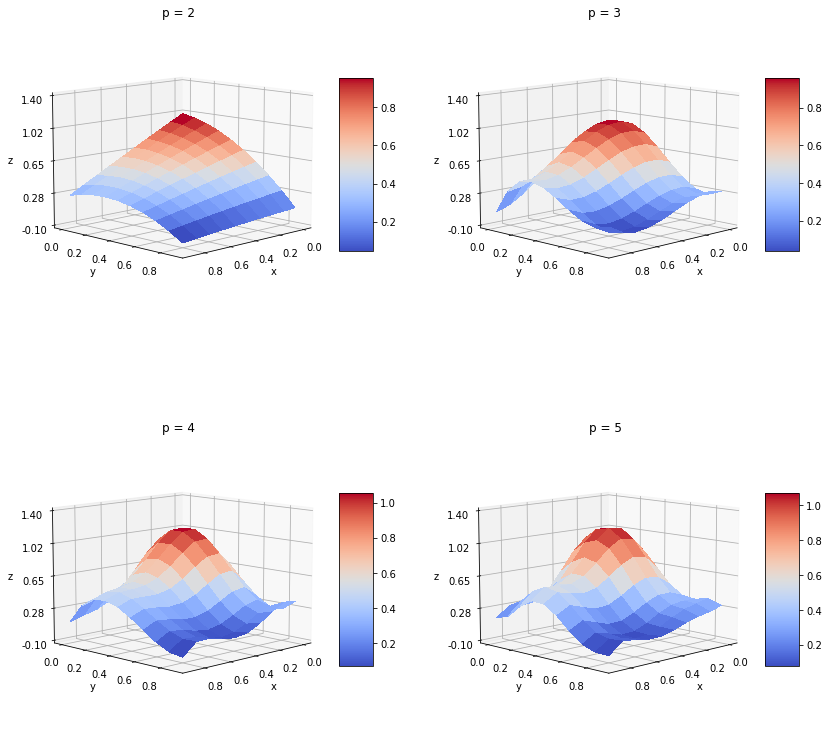

(10, 10)
(100,)
The R2 value for a polynomial of order 5, OLS test: -2.1726121951978863
The MSE value for a polynomial of order 5, OLS test: 1.978897172108493

The R2 value for a polynomial of order 5, OLS train: 0.3081895749050766
The MSE value for a polynomial of order 5, OLS train: 0.7264970886348502


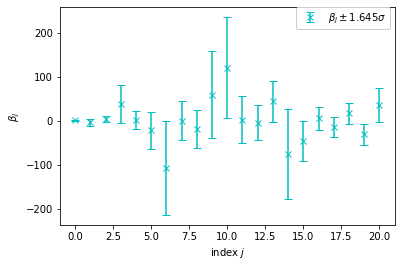

In [213]:
np.random.seed(26)

sig2 = 1 # noise variance
degree = 5 # polynomial degree
n = 10 # number of data points for each feature
x1, x2, y = createDataPoints(n, sig2)
plotFranke(x1,x2,5,'OLS')
print(x1.shape)
print(y.shape)
X = createDesignMatrix(x1,x2,degree)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train, X_test = Scale(X_train, X_test)

beta, _ = olsRegression(X_train, X_test, y_train, y_test, False)

# Calculate the confidence interval of the 'p' parameters beta
CIBeta(X_train, beta, "ols", 0)

b)

Polynomial degree: 0
Error: 0.8985052676340944
Bias^2: 0.883453863318446
Var: 0.015051404315648387
0.8985052676340944 >= 0.883453863318446 + 0.015051404315648387 = 0.8985052676340943

Polynomial degree: 1
Error: 1.1977237789157071
Bias^2: 1.1544076809013155
Var: 0.043316098014391416
1.1977237789157071 >= 1.1544076809013155 + 0.043316098014391416 = 1.197723778915707

Polynomial degree: 2
Error: 1.0663970790698016
Bias^2: 0.9716950138927378
Var: 0.09470206517706374
1.0663970790698016 >= 0.9716950138927378 + 0.09470206517706374 = 1.0663970790698016

Polynomial degree: 3
Error: 1.2737246290142774
Bias^2: 1.0855961808956844
Var: 0.18812844811859264
1.2737246290142774 >= 1.0855961808956844 + 0.18812844811859264 = 1.2737246290142772

Polynomial degree: 4
Error: 2.0414085179390096
Bias^2: 1.3216243610481853
Var: 0.7197841568908249
2.0414085179390096 >= 1.3216243610481853 + 0.7197841568908249 = 2.04140851793901

Polynomial degree: 5
Error: 2.7836767950168952
Bias^2: 1.3185632258271736
Var: 1.46

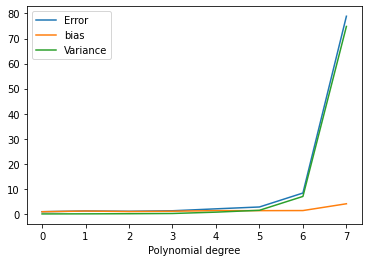

Polynomial degree: 0
Error: 1.146587108956278
Bias^2: 1.1456080485953086
Var: 0.0009790603609692635
1.146587108956278 >= 1.1456080485953086 + 0.0009790603609692635 = 1.1465871089562778

Polynomial degree: 1
Error: 1.078202155859302
Bias^2: 1.0754595190342917
Var: 0.0027426368250105127
1.078202155859302 >= 1.0754595190342917 + 0.0027426368250105127 = 1.0782021558593022

Polynomial degree: 2
Error: 1.009425377052907
Bias^2: 1.0039605851296285
Var: 0.0054647919232783245
1.009425377052907 >= 1.0039605851296285 + 0.0054647919232783245 = 1.009425377052907

Polynomial degree: 3
Error: 1.1159229239122381
Bias^2: 1.1081871281453757
Var: 0.007735795766862569
1.1159229239122381 >= 1.1081871281453757 + 0.007735795766862569 = 1.1159229239122384

Polynomial degree: 4
Error: 1.0648793398581737
Bias^2: 1.0485347449905789
Var: 0.01634459486759484
1.0648793398581737 >= 1.0485347449905789 + 0.01634459486759484 = 1.0648793398581737

Polynomial degree: 5
Error: 1.091720707735201
Bias^2: 1.0721304747798244


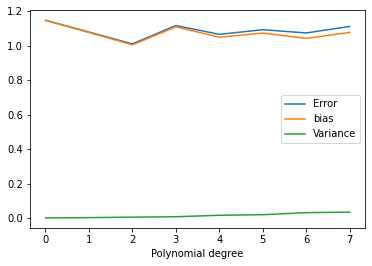

Polynomial degree: 0
Error: 0.9595820441660639
Bias^2: 0.9592403697898114
Var: 0.00034167437625220006
0.9595820441660639 >= 0.9592403697898114 + 0.00034167437625220006 = 0.9595820441660636

Polynomial degree: 1
Error: 0.9660743887501309
Bias^2: 0.9652081479108149
Var: 0.0008662408393160397
0.9660743887501309 >= 0.9652081479108149 + 0.0008662408393160397 = 0.966074388750131

Polynomial degree: 2
Error: 0.9669934995032183
Bias^2: 0.9653671749637196
Var: 0.001626324539498639
0.9669934995032183 >= 0.9653671749637196 + 0.001626324539498639 = 0.9669934995032182

Polynomial degree: 3
Error: 1.0010276565184688
Bias^2: 0.9983319024217969
Var: 0.002695754096671993
1.0010276565184688 >= 0.9983319024217969 + 0.002695754096671993 = 1.0010276565184688

Polynomial degree: 4
Error: 1.0300661765637085
Bias^2: 1.026257342276175
Var: 0.003808834287533276
1.0300661765637085 >= 1.026257342276175 + 0.003808834287533276 = 1.0300661765637082

Polynomial degree: 5
Error: 0.9489469724223699
Bias^2: 0.9434516105

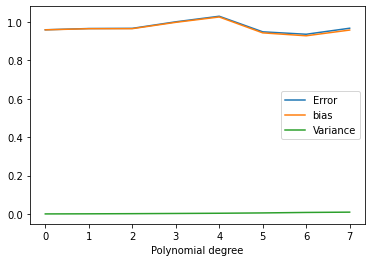

Polynomial degree: 0
Error: 1.087047576530833
Bias^2: 1.0869161615822474
Var: 0.00013141494858554635
1.087047576530833 >= 1.0869161615822474 + 0.00013141494858554635 = 1.087047576530833

Polynomial degree: 1
Error: 0.9886739641929535
Bias^2: 0.9882555185249928
Var: 0.0004184456679605999
0.9886739641929535 >= 0.9882555185249928 + 0.0004184456679605999 = 0.9886739641929534

Polynomial degree: 2
Error: 1.0157201239716303
Bias^2: 1.014783900789023
Var: 0.0009362231826073834
1.0157201239716303 >= 1.014783900789023 + 0.0009362231826073834 = 1.0157201239716303

Polynomial degree: 3
Error: 0.9538060675771579
Bias^2: 0.9523860803909641
Var: 0.0014199871861939849
0.9538060675771579 >= 0.9523860803909641 + 0.0014199871861939849 = 0.953806067577158

Polynomial degree: 4
Error: 0.9926632658744481
Bias^2: 0.9904858280819859
Var: 0.0021774377924621254
0.9926632658744481 >= 0.9904858280819859 + 0.0021774377924621254 = 0.9926632658744481

Polynomial degree: 5
Error: 0.989185089360417
Bias^2: 0.98616917

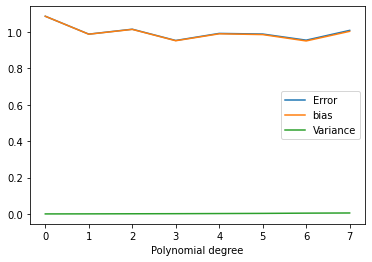

In [220]:
np.random.seed(26)

sig2 = 1 # noise variance
n = 10 # number of data points for each feature
n_boostraps = 200 # number of bootstraps 
maxdegree = 7 # maximum polynomial degree

for n in range(10,101, 30):
#     print(n)
    # Make data set.
    x1, x2, y = createDataPoints(n, sig2)
    x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)
#     print(x.shape)

    # Define empty arrays
    error = np.zeros(maxdegree+1)
    bias = np.zeros(maxdegree+1)
    variance = np.zeros(maxdegree+1)
    polydegree = np.zeros(maxdegree+1)


    for degree in range(maxdegree+1):

        X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
        
        # Split and scale the design data
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
        y_train, y_test = y_train[:, np.newaxis], y_test[:, np.newaxis]

        y_pred = np.empty((y_test.shape[0], n_boostraps))
        for i in range(n_boostraps):
            
            x_, y_ = resample(X_train, y_train)

            x_, X_test2 = Scale(x_, X_test)

            beta = np.linalg.pinv(x_.T.dot(x_)).dot(x_.T).dot(y_)
            y_pred[:, i] = (X_test2 @ beta).squeeze()

        polydegree[degree] = degree
        error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
        bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
        variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
        print("Polynomial degree:", degree)
        print("Error:", error[degree])
        print("Bias^2:", bias[degree])
        print("Var:", variance[degree])
        print('{} >= {} + {} = {}\n'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

    plt.plot(polydegree, error, label="Error")
    plt.plot(polydegree, bias, label="bias")
    plt.plot(polydegree, variance, label="Variance")
    plt.xlabel('Polynomial degree')
    plt.legend()
    plt.savefig('partBplot.jpg')
    plt.show()

c) Cross validation

In [201]:
np.random.seed(26)

sig2 = 1 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 5

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

print("Polynomial degree:", degree)

for k in K:

    #Split data set into k parts
    splitXData = np.array(np.split(X,k))
    splitYData = np.array(np.split(y,k))
    MSErrors = np.zeros(k)

    s0 = splitXData.shape[0]
    s1 = splitXData.shape[1]

    for i in range(0,k):
        mask = np.ones(k)
        mask[i]=0
        X_train = splitXData[mask==1].reshape(((s0-1)*s1,-1))
        X_test = splitXData[mask==0].squeeze()
        X_train, X_test = Scale(X_train, X_test)

        y_train = splitYData[mask==1].reshape(((s0-1)*s1,1))
        y_test = np.swapaxes(splitYData[mask==0], 0, 1)

        beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
        y_pred = (X_test @ beta)

        MSErrors[i] = np.mean((y_test - y_pred)**2, keepdims=True)
    MSError = np.mean(MSErrors)

    print("%s fold MSE:"% k, MSError)

Polynomial degree: 5
5 fold MSE: 1.4940634396608037
10 fold MSE: 1.2284097022385532


Compare our code for k-CV with that from scikit-learn

In [202]:
np.random.seed(26)

sig2 = 1 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 5

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

poly = PolynomialFeatures(degree = degree)

OLS = LinearRegression(fit_intercept=False)
X = poly.fit_transform(x)
X = X[p]
y = y[p]
estimated_mse_folds = cross_val_score(OLS, X, y[:, np.newaxis], scoring='neg_mean_squared_error', cv=10)

estimated_mse_sklearn = np.mean(-estimated_mse_folds)

print(estimated_mse_sklearn)

1.2284097022262457


d) Example of Ridge regression

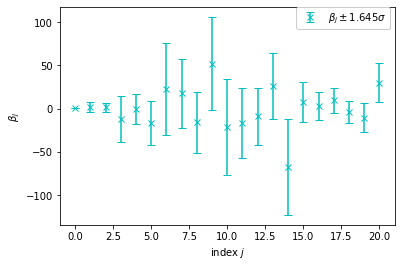

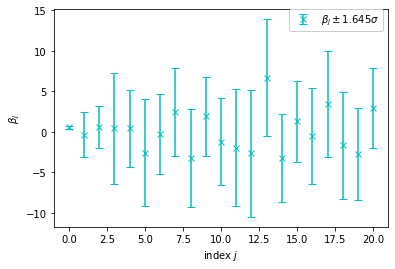

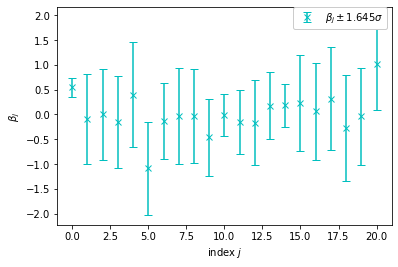

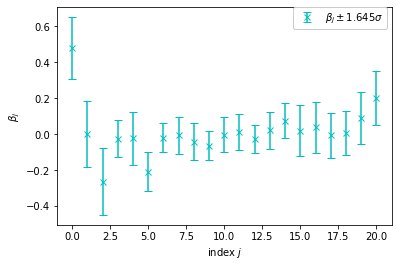

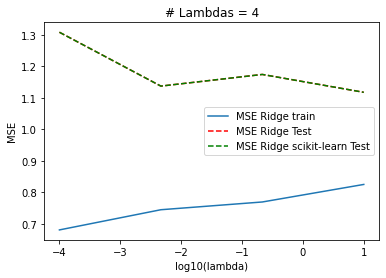

In [203]:
np.random.seed(26)

sig2 = 1 # noise variance
degree = 5 # polynomial degree
n = 10 # number of data points for each feature
x1, x2, y = createDataPoints(n, sig2)
X = createDesignMatrix(x1,x2,degree)
nlambdas = 4

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train, X_test = Scale(X_train, X_test)

_ = ridgeRegression(X_train, X_test,y_train,y_test, nlambdas=nlambdas, plot=True)

d) Perform bootstrapping with ridge

Polynomial degree: 0
Error: [0.88595245 0.88593618 0.8851862  0.85929265]
Bias^2: [0.88595245 0.88593618 0.8851862  0.85929265]
Var: [1.23259516e-32 1.23259516e-32 4.93038066e-32 3.08148791e-33]
[0.88595245 0.88593618 0.8851862  0.85929265] >= [0.88595245 0.88593618 0.8851862  0.85929265] + [1.23259516e-32 1.23259516e-32 4.93038066e-32 3.08148791e-33] = [0.88595245 0.88593618 0.8851862  0.85929265]

Polynomial degree: 1
Error: [1.15510131 1.15511184 1.15560098 1.17842858]
Bias^2: [1.12545342 1.12546807 1.12614715 1.15608567]
Var: [0.02964789 0.02964377 0.02945383 0.02234291]
[1.15510131 1.15511184 1.15560098 1.17842858] >= [1.12545342 1.12546807 1.12614715 1.15608567] + [0.02964789 0.02964377 0.02945383 0.02234291] = [1.15510131 1.15511184 1.15560098 1.17842858]

Polynomial degree: 2
Error: [1.05798377 1.05782938 1.05160409 1.03797121]
Bias^2: [0.97625639 0.97626931 0.97689177 1.00898056]
Var: [0.08172738 0.08156007 0.07471232 0.02899065]
[1.05798377 1.05782938 1.05160409 1.03797121] >

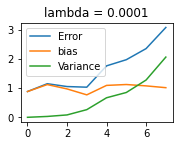

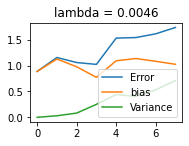

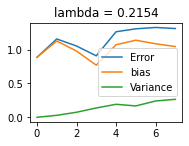

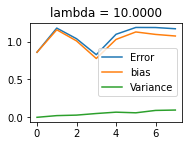

In [217]:
np.random.seed(26)

sig2 = 1 # noise variance
n = 10 # number of data points for each feature
n_boostraps = 200 # number of bootstraps 
maxdegree = 7 # maximum polynomial degree
nlambdas = 4

# for  in range(10,11):
# Make data set.
x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

BootStrapping("ridge", x, y, nlambdas=nlambdas, maxdegree=maxdegree, n_boostraps=n_boostraps)

d) Perform cross validation on ridge regression

In [205]:
np.random.seed(26)

sig2 = 1 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 5
nlambdas = 4

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

print("Polynomial degree:", degree)

_ = CrossValidation("ridge", X,y)

Polynomial degree: 5
5 fold MSE: [1.35510779 1.18666927 1.07311672 1.04672464]
10 fold MSE: [1.18463019 1.11022102 1.01568602 0.98668441]


e) Example of Lasso regression

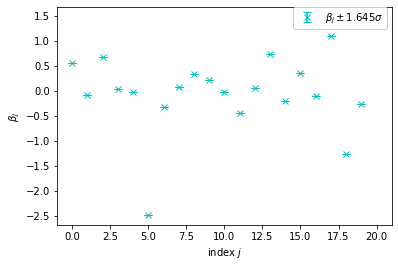

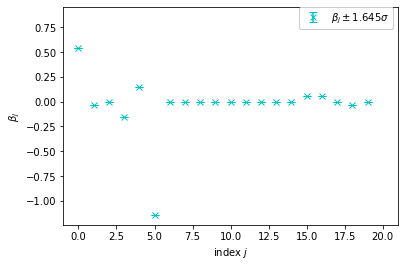

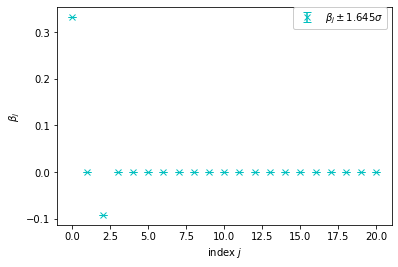

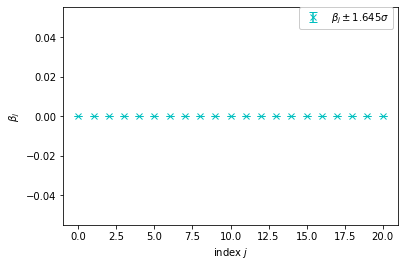

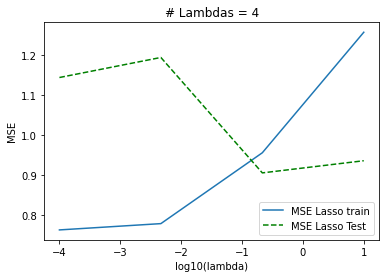

In [206]:
np.random.seed(26)

sig2 = 1 # noise variance
degree = 5 # polynomial degree
n = 10 # number of data points for each feature
x1, x2, y = createDataPoints(n, sig2)
X = createDesignMatrix(x1,x2,degree)
nlambdas = 4

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train, X_test = Scale(X_train, X_test)

_ = lassoRegression(X_train, X_test,y_train, y_test, nlambdas=nlambdas, plot=True)
# CIBeta(X=X_train, Beta=beta_lasso)

e) Performing bootstrapping with lasso regression

Polynomial degree: 0
Error: [0.88590702 0.88384884 0.83371113 0.93506352]
Bias^2: [0.88590702 0.88384884 0.83371113 0.93506352]
Var: [1.23259516e-32 1.23259516e-32 3.08148791e-33 0.00000000e+00]
[0.88590702 0.88384884 0.83371113 0.93506352] >= [0.88590702 0.88384884 0.83371113 0.93506352] + [1.23259516e-32 1.23259516e-32 3.08148791e-33 0.00000000e+00] = [0.88590702 0.88384884 0.83371113 0.93506352]

Polynomial degree: 1
Error: [0.83404586 0.83279807 0.88868571 1.08914237]
Bias^2: [0.80336883 0.80420358 0.88844048 1.08914237]
Var: [0.03067703 0.0285945  0.00024524 0.        ]
[0.83404586 0.83279807 0.88868571 1.08914237] >= [0.80336883 0.80420358 0.88844048 1.08914237] + [0.03067703 0.0285945  0.00024524 0.        ] = [0.83404586 0.83279807 0.88868571 1.08914237]

Polynomial degree: 2
Error: [0.95701678 0.93103425 0.96115909 1.16694939]
Bias^2: [0.85883726 0.85806236 0.96001097 1.16694939]
Var: [0.09817953 0.07297189 0.00114812 0.        ]
[0.95701678 0.93103425 0.96115909 1.16694939] >

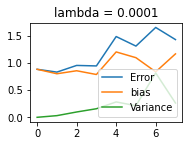

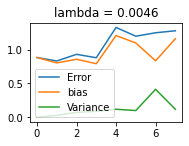

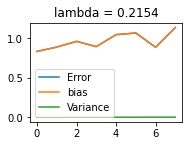

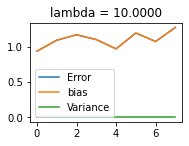

In [218]:
np.random.seed(26)

sig2 = 1 # noise variance
n = 10 # number of data points for each feature
n_boostraps = 200 # number of bootstraps 
maxdegree =7 # maximum polynomial degree
nlambdas = 4

# Make data set.
x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

BootStrapping("lasso", x, y, nlambdas=nlambdas, maxdegree=maxdegree, n_boostraps=n_boostraps)

e) Perform cross validation on lasso regression

In [219]:
np.random.seed(26)

sig2 = 1 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 5
nlambdas = 4

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

print("Polynomial degree:", degree)

_ = CrossValidation("lasso", X,y)

Polynomial degree: 5
5 fold MSE: [1.11622601 1.04937044 1.01572493 1.16012202]
10 fold MSE: [1.06023473 0.98223545 0.99486571 1.16012202]


f) Import and plot the terrain data

(3601, 1801)


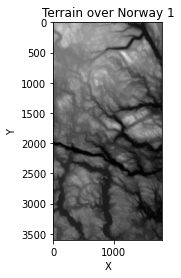

In [209]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')

print(terrain1.shape)
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('terrain2dplot.png')
plt.show()

The R2 value for a polynomial of order 25, OLS test: 0.9796003101912747
The MSE value for a polynomial of order 25, OLS test: 459.2342336799691

The R2 value for a polynomial of order 25, OLS train: 0.9804003662611247
The MSE value for a polynomial of order 25, OLS train: 452.64793330851927


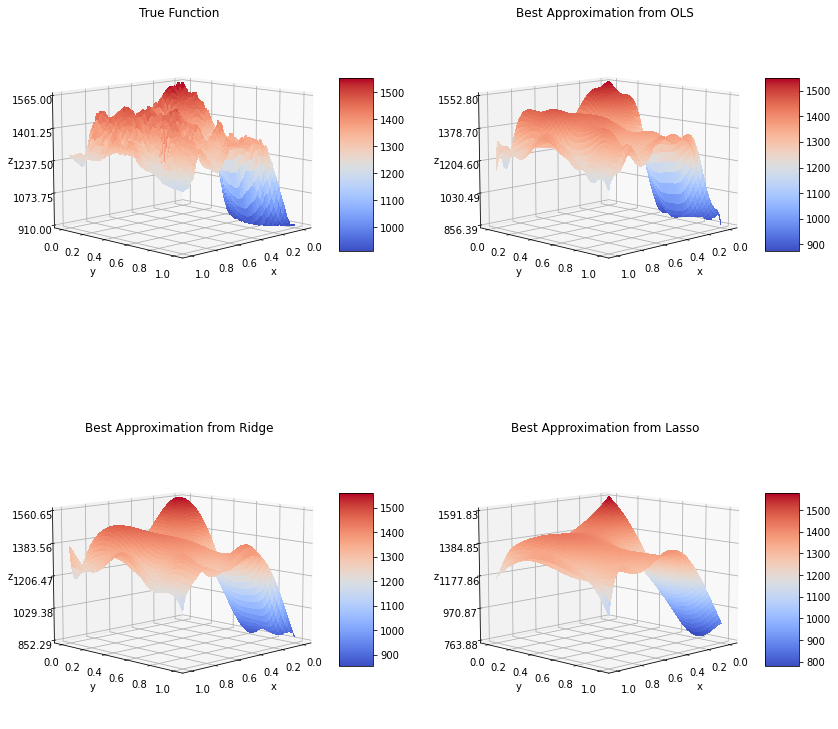

In [210]:
np.random.seed(26)

newLength = 200
startingPoint = 100
x1 = np.linspace(0,1,newLength)
x2 = np.linspace(0,1,newLength)
x1, x2 = np.meshgrid(x1,x2)

croppedTerrain = terrain1[startingPoint:newLength+startingPoint, startingPoint:newLength+startingPoint]
y = croppedTerrain.ravel()

degree = 25
X = createDesignMatrix(x1,x2,degree)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train, X_test = Scale(X_train, X_test)

_ = olsRegression(X_train, X_test, y_train,y_test, False)

scaler = StandardScaler()
scaler.fit(X[:,1:])
X[:,1:] = scaler.transform(X[:,1:])

beta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
y_OLS = (X @ beta)

clf_ridge = skl.Ridge(alpha=0.1, fit_intercept=False).fit(X,y)
y_Ridge = clf_ridge.predict(X).squeeze()

clf_lasso = skl.Lasso(alpha=0.1, fit_intercept=False).fit(X,y)
y_Lasso = clf_lasso.predict(X).squeeze()

Y = np.stack((y, y_OLS, y_Ridge, y_Lasso))
name = ["True Function", "Best Approximation from OLS", "Best Approximation from Ridge", "Best Approximation from Lasso"]

fig = plt.figure(figsize=(14,14))

for i in range(1,5):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    surf = ax.plot_surface(x1, x2, Y[i-1].reshape(newLength,newLength), cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(5))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.view_init(10, 45)
    ax.set_title(name[i-1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    fig.colorbar(surf, shrink=0.5, aspect=5)

In [31]:
newLength = 100
startingPoint = 100
x1 = np.linspace(0,1,newLength)
x2 = np.linspace(0,1,newLength)
x1, x2 = np.meshgrid(x1,x2)
K = [5, 10]
nlambdas = 4


croppedTerrain = terrain1[startingPoint:newLength+startingPoint, startingPoint:newLength+startingPoint]
y = croppedTerrain.ravel()

degree = 25
X = createDesignMatrix(x1,x2,degree)

# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
# X_train, X_test = Scale(X_train, X_test)
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

print("Cross validation with ridge:")
_ = CrossValidation("ridge", X, y)

print("Cross validation with lasso:")
_ = CrossValidation("lasso", X, y)

Cross validation with ridge:
5 fold MSE: [140.24758281 193.01693579 279.47366982 433.52387167]
10 fold MSE: [138.42340636 190.6176796  276.13550223 426.96509366]
Cross validation with lasso:
5 fold MSE: [ 432.53493805  429.83546397  621.28660359 4352.86134479]
10 fold MSE: [ 432.46637245  429.68040643  620.34978032 4350.88047866]
